
# Testing different ways of multiplying matices in Python

## Introduction
Python's time module provides various time-related functions. We are going to utilize it in order to calculate how long does it take to perform operations.
In this Homework, we will cover:

- The CUDA programming model
- Accelerating numerical python code with `numba`
- Implementing CUDA kernels in python
- Thread synchronization
- Shared memory

In [1]:
# Setup
%matplotlib inline
import os
import sys
import math
import time
import tqdm
import torch
import numpy as np
import matplotlib.pyplot as plt
import utils

In [2]:
plt.rcParams['font.size'] = 20
data_dir = os.path.expanduser('~/.pytorch-datasets')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if device.type != "cuda":
    raise RuntimeError("This tutorial requires a GPU!")

print(f"Using {device=!s}")

Using device=cuda


### Kernel "Geometry"

### Key idea of CUDA

- Write a single-threaded program with the **thread id** as a parameter.
- Use thread id to select a subset of data to process.
- Launch many threads, so that together they cover the entire range of input data.
- Code automatically scales to all available physical processors. 

<div>

<left>
<h3> Shared memory <h3/>
- Shared between threads in the same thread block
<br/>
- Used for collaboration between threads in the same block
<br/>
- On chip $\rightarrow$ very fast
<br/>
- Persisted until end of block
<br/>
<br/>
    
</left>

<right>
    
<h3> Global memory <h3/>
- Can be accessed by any thread in any thread block
    <br/>
- Used to copy to/from host
    <br/>
- Located in DRAM $\rightarrow$ slow
    <br/>
- Persisted for the life of the application
    <br/>
    <br/>

</right>
    
</div>    

In [17]:
    
plt_results(N_choices, cpu_times, numpy_times, cuda_naive_times, cuda_fast_times, to_scale = 'µs')


## Summary

## Heuristics for Kernel sizes

How many blocks?
- Should occupy every SM $\rightarrow$ At least one block per SM
- Should have something to run on SM if current block is waiting (e.g. sync) $\rightarrow$ At least two blocks per SM
- Should scale with same code if we upgrade hardware $\rightarrow$ Many blocks per SM!

How many threads?
- Many threads $\rightarrow$ hides global memory latency
- Too many threads $\rightarrow$ exhaust registers and shared memory
- Should be a multiple of warp size
- Typical selection: 64 to 512 per block

## Implementing CUDA Kernels with `numba`

### What is `numba`?

Numba is a **just-in-time** (JIT) **function compiler**, focused on **numerical python**.
It can be used to accelerate python code by generating efficient, **type-specialized** machine code.
Numba supports all major OSes and a wide range of hardware (Intel x86/64, NVIDIA CUDA, ARM).
It's developed and actively maintained by Anaconda Inc., and considered production ready.


### First steps with `numba` on the GPU

In [3]:
import numpy as np
import numba
from numba import cuda

# Show GPUs on the machine
cuda.detect()

Found 1 CUDA devices
id 0             b'TITAN Xp'                              [SUPPORTED]
                      compute capability: 6.1
                           pci device id: 0
                              pci bus id: 7
Summary:
	1/1 devices are supported


True

# multiplication accumulation : D = AxB + C

### CPU implementation
#### Pure Python implementation 
Our implementation will be purely based on Python. We will not use any external libraries. We need three loops here. The first loop is for all rows in first matrix, 2nd one is for all columns in second matrix and 3rd one is for all values within each value in the i row and j column of matrices a and b respectively. We need to multiply each elements of i row and j column together and finally sum the values. The final sum is the value for D[i, j].



In [4]:


def cpu_matmul_add(A, B, C, D):
    N = A.shape[0]
    for i in range(N): 
        for j in range(N):
            D[i, j] = C [i, j]
            for k in range(N):
                D[i, j] += A[i, k] * B[k, j]
                
          

In [5]:
# Kernel geometry: cover the entire matrix with the grid
N = 64

# Input data 
a = np.random.rand(N, N) 
b = np.random.rand(N, N) 
c = np.random.rand(N, N) 
cpu_out = np.zeros((N, N), dtype=np.float32)


print('\nCPU matmul_add:')
%timeit -o -r 1 -n 1 pass;  cpu_matmul_add(a, b, c, cpu_out)


print('')


CPU matmul_add:
791 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)



### GPU naive implementation kernel

In [6]:
@cuda.jit
def matmul_add_kernel(A, B, C, D):
    
    # Unique thread id on a 2d-grid
    i, j = cuda.grid(2)           # location of current thread (i, j)
    imax, jmax = cuda.gridsize(2) # total number of threads (I, J)

    # Each thread calculates one output element: out[i,j]
    if i < D.shape[0] and j < D.shape[1]:
        for k in range(B.shape[0]):
            D[i, j] += A[i,k] * B[k,j]
        D[i, j] += C[i,j]
            

##### 2D kernel geometry set up and random matrix decleration. 

In [7]:


blocksize = cuda.get_current_device().WARP_SIZE
gridsize = (N + blocksize-1)//blocksize

block_dim = (blocksize, blocksize)
grid_dim = (gridsize, gridsize)

print(f'block_dim={block_dim}, grid_dim={grid_dim}')
print(f'total_threads={(blocksize**2) * (gridsize**2)}')



block_dim=(32, 32), grid_dim=(2, 2)
total_threads=4096


##### Testing and comperation of numpy and cpu implementation:
##### Let's try our simple kernel and compare it to numpy

In [8]:

expected_out = np.matmul(a, b) + c

out = np.zeros((N, N), dtype=np.float32)
matmul_add_kernel[grid_dim, block_dim](a, b, c, out)

# Make sure result is correct
assert(np.allclose(out, expected_out))
out

array([[16.28223  , 15.488041 , 15.125814 , ..., 17.013523 , 16.98449  ,
        15.143689 ],
       [16.821674 , 17.227692 , 17.309969 , ..., 15.40683  , 16.033924 ,
        14.614565 ],
       [17.841513 , 18.137138 , 16.837236 , ..., 17.617714 , 19.809275 ,
        16.196302 ],
       ...,
       [17.627274 , 16.708979 , 16.101015 , ..., 16.14629  , 17.794588 ,
        15.0994215],
       [17.181337 , 17.296556 , 16.811516 , ..., 16.71122  , 18.70209  ,
        15.767479 ],
       [15.714673 , 15.635249 , 16.658735 , ..., 14.713628 , 16.041458 ,
        13.472644 ]], dtype=float32)

In [9]:

print('\nGPU, naive implementation:')
%timeit matmul_add_kernel[grid_dim, block_dim](a, b, c, out); cuda.synchronize()



GPU, naive implementation:
2.16 ms ± 8.94 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


That's about 2k orders of magnitude faster! Not bad for just adding a decorator function...
We used lots of threads and a large grid!
But, why is this implementation still inefficient?

Both A and B will be read many times from the **slow** global memory:
- A will be read `B.shape[1]` times
- B will be read `A.shape[0]` times

Now we can move on to a more efficient version which takes take advantage of **shared memory** to reduce
global memory bandwidth.
Recall that shared memory is on-chip memory available on each streaming multiprocessor.
It is shared only between threads of the same block (even if other blocks are running on the same SM).
Shared memory is scarce hardware resource, in many cases limited to 48kB per block. It should be used sparingly, as a way to reduce latency of global memory.

We will implement as follows:

- Each thread block is responsible for computing one square sub-matrix `D_sub` of the output `D`, of shape `(blocksize,blocksize)`.
- Each thread within the block is responsible for computing one element of `D_sub`.
- `D_sub` is the product of two rectangular matrices: `A_sub` of shape `(block_size, A.shape[1])` which has the same row indices as `D_sub`, and `B_sub` of shape `(B.shape[0], blocksize)` which has the same column indices as `Dsub`. Then adding from his own cell from matrix `C` to the result.  
- These two rectangular matrices are divided into as many square matrices of shape `(blocksize, blocksize)` as necessary.
- `D_sub` is computed as the sum of the products of these square matrices. To compute this product:
    - First we load two corresponding square matrices from global memory to shared memory with one thread loading one element of each matrix.
    - Then each thread computes one element of the product using the shared memory.
    - Each thread accumulates the result of each of these square products into a register and once done writes the result to global memory.
    - Then we load square matrices from global memory of `C` matrix to shared memory with one thread loading one element of the matrix.

In [10]:
@cuda.jit
def fast_matmul_add_kernel(a, b, c, out):
    # Define arrays in the shared memory
    # These will hold a square block of A_sub and B_sub
    # The size and type of the arrays must be known at compile time
    a_sub = cuda.shared.array(shape=(blocksize, blocksize), dtype=numba.float32)
    b_sub = cuda.shared.array(shape=(blocksize, blocksize), dtype=numba.float32)
    c_sub = cuda.shared.array(shape=(blocksize, blocksize), dtype=numba.float32)

    # Global id of current thread in a 2D threadblock: defines output location
    x, y = cuda.grid(2)
    
    # Bounds check
    if x >= out.shape[0] or y >= out.shape[1]:
        return
    
    # Index of thread within it's own block
    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    bpg = cuda.gridDim.x    # blocks per grid

    # Each thread computes one element in the result matrix.
    # The dot product is chunked into dot products of (blocksize,)-shaped vectors.
    tmp = 0.
    for i in range(bpg):
        # i is the index of the current inner square block
        
        # Get row and col within A_sub and B_sub and do bounds check
        b_sub_row = tx + i * blocksize
        a_sub_col = ty + i * blocksize
        if not (b_sub_row < b.shape[0] and a_sub_col < a.shape[1]):
            continue
        
        # Preload one element from A_sub and B_sub into shared memory
        a_sub[tx, ty] = a[x, a_sub_col]
        b_sub[tx, ty] = b[b_sub_row, y]

        # Wait for all threads in current block
        cuda.syncthreads()

        # Compute inner product between vectors, read from the shared memory
        for j in range(blocksize):
            tmp += a_sub[tx, j] * b_sub[j, ty]
        
        cuda.syncthreads()

        
    # Preload one element from C_sub into shared memory
    c_sub[tx, ty] = c[x, y]
    # Write to global memory
    out[x, y] = tmp + c_sub[tx, ty]
    

What does the `cuda.syncthreads()` call do?

Why do we need the first call? And why do we need to second?

This call allows us to use a synchronization mechanism called a **barrier**, between threads within the **same** threadblock.

A barrier blocks each thread until all threads reach it, at which point all threads become unblocked.

- The first `syncthreads()` call is needed in order to wait for the entire `a_sub` and `b_sub` matrices to fill, since each thread loads only one element.
- The second `syncthreads()` is necessary so that a thread will not advance to the next square sub-block. This will cause it to fetch new data into `a_sub` and `b_sub` while another thread might still need the old data.

Let's test our faster matrix multiplication:

In [11]:
out = np.zeros((N, N), dtype=np.float32)

fast_matmul_add_kernel[grid_dim, block_dim](a, b, c, out)

# Make sure result is correct
assert(np.allclose(out, expected_out))
out

array([[16.28223  , 15.488042 , 15.125815 , ..., 17.013521 , 16.98449  ,
        15.143691 ],
       [16.821676 , 17.227694 , 17.309969 , ..., 15.406833 , 16.033924 ,
        14.614565 ],
       [17.841515 , 18.137135 , 16.837234 , ..., 17.617718 , 19.809277 ,
        16.1963   ],
       ...,
       [17.627272 , 16.708984 , 16.101013 , ..., 16.146294 , 17.794588 ,
        15.0994215],
       [17.181337 , 17.296555 , 16.811516 , ..., 16.711218 , 18.70209  ,
        15.767479 ],
       [15.714674 , 15.635251 , 16.658735 , ..., 14.713627 , 16.041458 ,
        13.472643 ]], dtype=float32)

In [12]:

print('\nGPU, with shared memory:')
%timeit fast_matmul_add_kernel[grid_dim, block_dim](a, b, c, out); cuda.synchronize()



GPU, with shared memory:
2.1 ms ± 26.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


That's about 2 orders of magnitude faster from gpu naive  implementation,f for more large matrix we will see that it will improves significantly. 
Now we can benchmark the performance.
A timer function that takes in the function to be timed and its arguments. It then defines an equivalent (lambda) function with no arguments and times it.

#### Test for the basic size 64x64

In [13]:
from utils import *

d_a = cuda.to_device(a)
d_b = cuda.to_device(b)
d_c = cuda.to_device(c)
d_out = cuda.to_device(np.zeros((N, N), dtype=np.float32))
tmp_out = np.zeros((N, N), dtype=np.float32)



numpy_func = lambda: (np.matmul(a, b, out=tmp_out) + c)   
cpu_func = lambda: cpu_matmul_add(a, b, c, cpu_out)
gpu_naive = lambda: matmul_add_kernel[grid_dim, block_dim](d_a, d_b, d_c, d_out); cuda.synchronize()
gpu_fast = lambda: fast_matmul_add_kernel[grid_dim, block_dim](d_a, d_b, d_c, d_out); cuda.synchronize()

default_config = (7, 10, 'µs')
cpu_config = (7, 1, 'ms')


functions_dict = {'NUMPY' : (numpy_func, 'numpy matmul add', *default_config),
                 'CPU' : (cpu_func, 'CPU matmul add', *cpu_config),
                 'GPU_NAIVE' : (gpu_naive, 'GPU, naive implementation',  *default_config),
                 'GPU_FAST' : (gpu_fast, 'GPU, with shared memory',  *default_config),
                 }

time_measurement(*functions_dict['CPU'])
time_measurement(*functions_dict['GPU_NAIVE'])
time_measurement(*functions_dict['GPU_FAST'])
time_measurement(*functions_dict['NUMPY'])

print()




CPU matmul add:
788.40855 ms average time per run (mean of 7 runs, 1 loops each)

GPU, naive implementation:
255.57033 µs average time per run (mean of 7 runs, 10 loops each)

GPU, with shared memory:
232.20004 µs average time per run (mean of 7 runs, 10 loops each)

numpy matmul add:
68.54478 µs average time per run (mean of 7 runs, 10 loops each)



# run experiments for matrix of sizes: `32x32` ,  `128x128` ,  `512x512` , `1024x1024`

In [14]:
# run experiments

N_choices = [32, 128, 512, 1024]

def run_experiment(N):
    
    print('\n' + '=' * 75)
    print(f'=========== [ matrix multiplication of {N:^5d} x {N:^5d} elements ] ===========')
    print('=' * 75)
    blocksize = cuda.get_current_device().WARP_SIZE
    gridsize = (N + blocksize-1)//blocksize

    block_dim = (blocksize, blocksize)
    grid_dim = (gridsize, gridsize)
    
    print(f'block_dim={block_dim}, grid_dim={grid_dim} , total_threads={(blocksize**2) * (gridsize**2)}')

    tmp_out = np.zeros((N, N), dtype=np.float32)
    # Input data 
    a = np.random.rand(N, N) 
    b = np.random.rand(N, N) 
    c = np.random.rand(N, N) 
    cpu_out = np.zeros((N, N), dtype=np.float32)

    d_a = cuda.to_device(a)
    d_b = cuda.to_device(b)
    d_c = cuda.to_device(c)
    d_out = cuda.to_device(np.zeros((N, N), dtype=np.float32))

    print('\nCPU matmul add:')
    cpu_time = %timeit -o -r 1 -n 1 pass; cpu_matmul_add(a, b, c, cpu_out)
    print_time(cpu_time)
    

    print('\nnumpy matmul add:')
    numpy_time = %timeit -o -r 5 -n 100  pass; (np.matmul(a, b, out=tmp_out) + c)
    print_time(numpy_time)
    
    
    print('\nGPU, naive implementation:')
    cuda_naive_time =  %timeit -o -r 5 -n 100 pass; matmul_add_kernel[grid_dim, block_dim](d_a, d_b, d_c, d_out); cuda.synchronize()
    print_time(cuda_naive_time)

    print('\nGPU, with shared memory:')
    cuda_fast_time =  %timeit -o -r 5 -n 100 pass; fast_matmul_add_kernel[grid_dim, block_dim](d_a, d_b, d_c, d_out); cuda.synchronize()
    print_time(cuda_fast_time)
    
    return cpu_time, numpy_time, cuda_naive_time, cuda_fast_time 


    

### Note: This step might take a while, we used save_checkpoint strategy, the final checkpoints file will be loaded instead of running training.
### if you want to run experiment, change the `force_run` below to True.


In [15]:
import json
import utils 

force_run = False
results_file_path = os.path.join('exp.results.out')

cpu_times, numpy_times, cuda_naive_times, cuda_fast_times = [], [], [], [] 


if not force_run and os.path.isfile(results_file_path):

    with open(results_file_path, 'r') as f:
        results = json.load(f)
        cpu_times = results['CPU']
        numpy_times = results['NUMPY']
        cuda_naive_times = results['GPU_NAIVE']
        cuda_fast_times = results['GPU_FAST']
        
    for i, N in enumerate(N_choices):
        print('\n' + '=' * 75)
        print(f'=========== [ matrix multiplication of {N:^5d} x {N:^5d} elements ] ===========')
        print('=' * 75)
        
        print('\nCPU matmul add:')
        print_time_from_file(cpu_times, i)

        print('\nnumpy matmul add:')
        print_time_from_file(numpy_times, i)


        print('\nGPU, naive implementation:')
        print_time_from_file(cuda_naive_times, i)

        print('\nGPU, with shared memory:')
        print_time_from_file(cuda_fast_times, i)


else: 
    for N in N_choices:
        cpu_time, numpy_time, cuda_naive_time, cuda_fast_time = run_experiment(N)
        cpu_times.append(cpu_time)
        numpy_times.append(numpy_time)
        cuda_naive_times.append(cuda_naive_time)
        cuda_fast_times.append(cuda_fast_time)

    print('\nCPU matmul add:')
    print_time_from_file(cpu_times, i)

    print('\nnumpy matmul add:')
    print_time_from_file(numpy_times, i)


    print('\nGPU, naive implementation:')
    print_time_from_file(cuda_naive_times, i)

    print('\nGPU, with shared memory:')
    print_time_from_file(cuda_fast_times, i)    

    results_dict = {'CPU' : [time_result_to_dict(t) for t in cpu_times],
                    'NUMPY' : [time_result_to_dict(t) for t in numpy_times],
                    'GPU_NAIVE' : [time_result_to_dict(t) for t in cuda_naive_times],
                    'GPU_FAST' : [time_result_to_dict(t) for t in cuda_fast_times],
                     }
    
    with open(results_file_path , 'w') as f:
        json.dump(results_dict, f)    
    
    


=========== [ matrix multiplication of  32   x  32   elements ] ===========

CPU matmul add:

        Average time (ms) 28.1
           Best time (ms) 28.1
                 Std (ns) 0.0

numpy matmul add:

        Average time (µs) 16.5
           Best time (µs) 13.1
                 Std (µs) 3.1

GPU, naive implementation:

        Average time (µs) 340.4
           Best time (µs) 325.2
                 Std (µs) 11.1

GPU, with shared memory:

        Average time (µs) 299.1
           Best time (µs) 296.2
                 Std (µs) 5.2

=========== [ matrix multiplication of  128  x  128  elements ] ===========

CPU matmul add:

        Average time (ms) 984.1
           Best time (ms) 984.1
                 Std (ns) 0.0

numpy matmul add:

        Average time (µs) 83.3
           Best time (µs) 82.0
                 Std (µs) 2.3

GPU, naive implementation:

        Average time (µs) 455.1
           Best time (µs) 407.5
                 Std (µs) 24.9

GPU, with shared memory:

    

In [16]:
import utils 
import pandas as pd
from IPython.display import display, HTML


df = get_summary_table(N_choices, cpu_times, numpy_times, cuda_naive_times, cuda_fast_times)

def hover(hover_color="#ffff99"):
    return dict(selector="tr:hover", props=[("background-color", "%s" % hover_color)])

styles = [hover(), dict(props=[('width', '1000px'), ("font-size", "16pt"),("text-align", "center")])]
html = (df.style.set_table_styles(styles))
html



,CPU,numpy,"GPU, naive","GPU, fast"
32 x 32,28.1 (ms),16.5 (µs),340.4 (µs),299.1 (µs)
128 x 128,984.1 (ms),83.3 (µs),455.1 (µs),245.4 (µs)
512 x 512,60.0 (s),3.5 (ms),5.5 (ms),2.7 (ms)
1024 x 1024,465.2 (s),24.1 (ms),40.9 (ms),21.0 (ms)


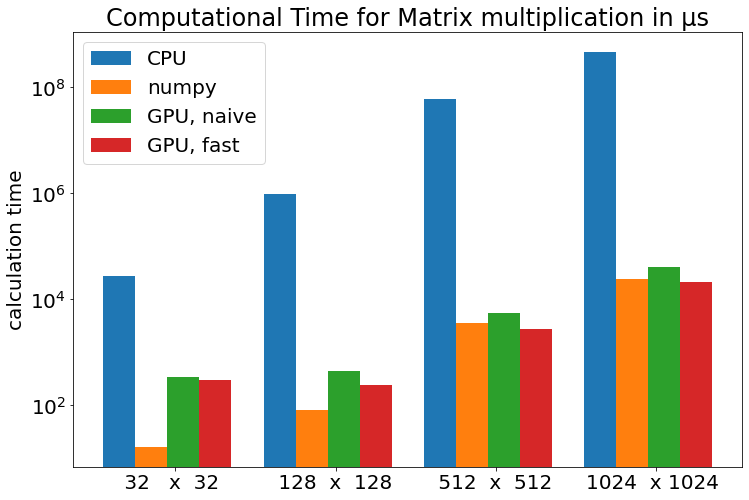

In [17]:
    
plt_results(N_choices, cpu_times, numpy_times, cuda_naive_times, cuda_fast_times, to_scale = 'µs')


## Summary

- CUDA provides a very powerful framework for easily writing highly scalable multithreaded code.
- Once we have the right mental model about how it works, we can leverage the power of GPUs for performing arbitrary computation.
- Using `numba`, we can do this directly in Python, and even iterate implementing our GPU code interactively within a jupyter notebook.
- As a bonus, we learned how to accelerate any numerical python function with `numba`, and squeeze out extra performance gains even without a GPU.

- As we can see, performing the same operation on a GPU gives us a speed-up of 70 times as on CPU.
  This was still a small computation. For large scale computations, GPUs give us speed-ups of a few orders of magnitude.

- For large scale computations, GPUs give us speed-ups even better than `numpy` !

## Thanks!